### Img, question, cross_attn_out are concatenated together
### Two norms
### Use Large_vocab_Epoch0002 weights
### vocab size 5500, stored in token_vocab
### whole model saved in VQA_final_model

In [3]:
pip install tensorflow_text
pip install transformers
pip install tensorflow_hub
pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 88.3 MB/s eta 0:00:00


In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt

import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
import tensorflow_hub as hub
import tensorflow_text as text
from model import QAModel
from transformers import AutoImageProcessor, TFViTModel
import torch

In [5]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [9]:
ans_tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=None,
    standardize=None,
    ngrams = 3,
    output_sequence_length=1
)
ans_tokenizer.set_vocabulary('/content/drive/MyDrive/tokn_vocab')


In [10]:
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=ans_tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=ans_tokenizer.get_vocabulary(),
    invert=True)

In [12]:
image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch32-224-in21k")
vit_model = TFViTModel.from_pretrained("google/vit-base-patch32-224-in21k")
vit_model.trainable = True

All model checkpoint layers were used when initializing TFViTModel.

All the layers of TFViTModel were initialized from the model checkpoint at google/vit-base-patch32-224-in21k.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


In [20]:
preprocessing_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", name='preprocessing')
encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1", trainable=True, name='BERT_encoder')

In [41]:
model = QAModel(vit_model=vit_model, bert_encoder=encoder)
model.load_weights('/content/drive/MyDrive/Large_vocab_Epoch0002/cp-0002.ckpt')

In [42]:
# question = [
#             'what is the person doing',
#             'what color is his coat',
#             'how many people are there in the photo',
#             'is he playing basketball',
#             'is he skiing',
#             'is there a bus in the background',
#             'is the man wearing glasses',
#             'what is the man sitting on',
#             'what color is the sause on the hot dog that he is holding',
#             'what color is the bread of the hot dog that he is holding']

# question = ['what is the man doing',
#             'is he playing basketball',
#             'is the snowboarder in the air',
#             'is the snowboarder on the ground',
#             'how many people are there in the picture',
#             'what color is the snowboard',
#             'is the man on the ground taking photos',
#             'is the man in the air sknowboarding',
#             'is the man on the ground sknowboarding',
#             'Are the man in the air and the man on the ground both sknowboarding',
#             'will the snowboarder fall on the ground',
#             'will the snowboarder land safely']

question = ['what color is his coat',
            'what color is his hat']

In [ ]:
# img_path = img_names[0]
# print(img_path)
# /content/data/train2014/train2014/COCO_train2014_000000188723.jpg

/content/data/train2014/train2014/COCO_train2014_000000188723.jpg


tf.Tensor([[b'red']], shape=(1, 1), dtype=string)
tf.Tensor([[b'black']], shape=(1, 1), dtype=string)


(-0.5, 223.5, 223.5, -0.5)

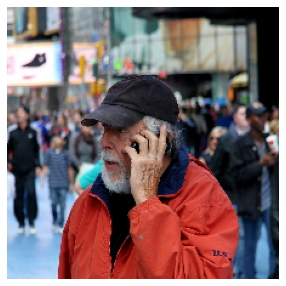

In [43]:
lemmatizer = WordNetLemmatizer()
img = tf.io.read_file('/content/COCO_val2014_000000000395.jpg')
img = tf.io.decode_jpeg(img, channels=3)
img = tf.keras.layers.Resizing(224, 224)(img)
img = img/255
img = tf.transpose(img)
img = tf.expand_dims(img, 0)
for q in question:
  tokens = word_tokenize(q)
  tokens = [t.lower() for t in tokens if t not in '''!,.;?()-[]{};:'"\<>/@#$+%^&*_~''']
  tokens = [lemmatizer.lemmatize(t) for t in tokens]
  q = " ".join(tokens)
  q = tf.expand_dims(q, 0)
  predictions = model((img, q))
  prediction = tf.argmax(predictions, axis=-1)
  print(index_to_word(prediction))

img = plt.imread('/content/COCO_val2014_000000000395.jpg')
resized_image = tf.image.resize(
  tf.convert_to_tensor([img]), size=(224, 224)
)
## Scaling the images
resized_image = resized_image/255.
plt.figure(figsize =  (5,  5))
plt.imshow(resized_image[0])
plt.axis("off")